In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Eyeglasses_Removal-main"

/content/drive/MyDrive/Eyeglasses_Removal-main


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# import sys
# sys.path.append('./PIX2PIX')
# from pix2pix_model import Discriminator, Generator
from PIX2PIX.pix2pix_model import Discriminator, Generator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Path to save model
log_path = "./PIX2PIX/log"

# Define the paths to input and target data folders for train
train_input_data_paths = [
    './MaskData/train_samples/after_thk7',
    './MaskData/train_samples/after_thk5',
    './MaskData/train_samples/no_damage'
]
train_target_data_paths = [
    './MaskData/train_samples/before_morphk7',
    './MaskData/train_samples/before_morphk7',
    './MaskData/train_samples/no_damage'
]

# Define the paths to input and target data folders for validation
val_input_data_paths = [
    './MaskData/validation_samples/after_thk7',
    './MaskData/validation_samples/after_thk5',
    './MaskData/validation_samples/no_damage'
]
val_target_data_paths = [
    './MaskData/validation_samples/before_morphk7',
    './MaskData/validation_samples/before_morphk7',
    './MaskData/validation_samples/no_damage'
]

In [ ]:
# Define the paths to input and target data folders for train
print(len(os.listdir('./MaskData/train_samples/before_morphk7')))
print(len(os.listdir('./MaskData/train_samples/before_morphk5')))
print(len(os.listdir('./MaskData/train_samples/no_damage')))

print(len(os.listdir('./MaskData/train_samples/after_thk7')))
print(len(os.listdir('./MaskData/train_samples/after_thk5')))

2500
2000
500
2500
2000


In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, input_data_paths, target_data_paths, transform=None):
        self.input_data_paths = input_data_paths
        self.target_data_paths = target_data_paths
        self.transform = transform

        self.input_images = []
        self.target_images = []

        # Load images from all input and target data folders
        for input_data_path, target_data_path in zip(input_data_paths, target_data_paths):
            input_images = sorted([os.path.join(input_data_path, img) for img in os.listdir(input_data_path)])
            target_images = sorted([os.path.join(target_data_path, img) for img in os.listdir(target_data_path)])

            self.input_images.extend(input_images)
            self.target_images.extend(target_images)

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        input_image_path = self.input_images[idx]
        target_image_path = self.target_images[idx]

        input_image = Image.open(input_image_path).convert('RGB')
        target_image = Image.open(target_image_path).convert('RGB')

        # Convert to tensors and transpose
        input_image = transforms.ToTensor()(input_image)
        target_image = transforms.ToTensor()(target_image)

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

In [ ]:
# Define data transformations (e.g., resizing, normalization)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Normalize((0.5,),(0.5,)),
])

# Hyperparameters
batch_size = 4
num_workers = 0

# Create custom datasets for training and validation
train_dataset = CustomImageDataset(train_input_data_paths, train_target_data_paths, transform=transform)
val_dataset = CustomImageDataset(val_input_data_paths, val_target_data_paths, transform=transform)

# Create data loaders for batch processing for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


In [ ]:
num_samples = len(train_dataset)
print("Number of samples in train_dataset:", num_samples)

Number of samples in train_dataset: 5000


# **Defining parameters**

In [ ]:
epochs = 17
L1_lambda = 100.0
in_w = in_h = 256

# **Initializing the models**

In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)


G_optimizer = optim.Adam(G.parameters(), lr=2e-4,betas=(0.5,0.999))
D_optimizer = optim.Adam(D.parameters(), lr=2e-4,betas=(0.5,0.999))

bce_criterion = nn.BCELoss()
L1_criterion = nn.L1Loss()

# **An instance of the input and target and predicted image before training**

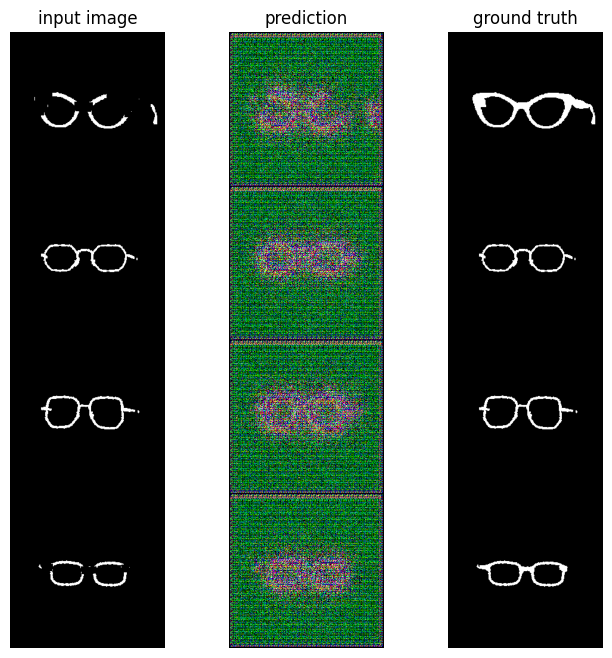

In [ ]:
fix_X, fix_y = next(iter(train_loader))
fix_X, fix_y = fix_X.to(device), fix_y.to(device)

def compare_batches(batch1, batch2, title1, title2, title3, batch3=None):
    # batch1
    plt.figure(figsize=(8,8))
    plt.subplot(1,3,1)
    plt.axis("off")
    plt.title(title1)
    plt.imshow(np.transpose(vutils.make_grid(batch1, nrow=1, padding=2,
    normalize=True).cpu(), (1,2,0)))
    # batch2
    plt.subplot(1,3,2)
    plt.axis("off")
    plt.title(title2)
    plt.imshow(np.transpose(vutils.make_grid(batch2, nrow=1, padding=2,
    normalize=True).cpu(), (1,2,0)))
    # third batch
    if batch3 is not None:
        plt.subplot(1,3,3)
        plt.axis("off")
        plt.title(title3)
        plt.imshow(np.transpose(vutils.make_grid(batch3, nrow=1, padding=2,
        normalize=True).cpu(), (1,2,0)))

fix_X = fix_X.to(device)

with torch.no_grad():
    fk = G(fix_X)

threshold = 0.5
fk = (fk > threshold).float()

compare_batches(fix_X, fk, "input image", "prediction", "ground truth", fix_y)

# **Training the model**

In [ ]:
G_losses = D_losses = G_GAN_losses = G_L1_losses = []
best_val_loss = float('inf')  # Initialize with a large value


for ep in range(epochs):
 for i, data in enumerate(train_loader):

   x, y = data
   x = x.to(device)
   y = y.to(device)

   b_size = x.shape[0]

   real_class = torch.ones(b_size,1,30,30).to(device)
   fake_class = torch.zeros(b_size,1,30,30).to(device)

   #Train D
   D.zero_grad()

   real_patch = D(y, x)
   real_gan_loss=bce_criterion(real_patch,real_class)

   fake=G(x)

   fake_patch = D(fake.detach(), x)
   fake_gan_loss=bce_criterion(fake_patch, fake_class)

   D_loss = real_gan_loss + fake_gan_loss
   D_loss.backward()
   D_optimizer.step()

   #Train G
   G.zero_grad()
   fake_patch = D(fake, x)
   fake_gan_loss=bce_criterion(fake_patch,real_class)

   L1_loss = L1_criterion(fake, y)
   G_loss = fake_gan_loss + L1_lambda*L1_loss
   G_loss.backward()

   G_optimizer.step()

   if (i+1)%125 == 0 :
     print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f},D(real): {:.2f}, D(fake):{:.2f},g_loss_gan:{:.4f},g_loss_L1:{:.4f}'
           .format(ep, epochs, i+1, len(train_loader), D_loss.item(), G_loss.item(),real_patch.mean(), fake_patch.mean(),fake_gan_loss.item(),L1_loss.item()))
     G_losses.append(G_loss.item())
     D_losses.append(D_loss.item())
     G_GAN_losses.append(fake_gan_loss.item())
     G_L1_losses.append(L1_loss.item())

     val_loss = 0.0
     with torch.no_grad():
      G.eval()  # Set the model to evaluation mode
      for val_batch in val_loader:
          val_input, val_target = val_batch
          val_input = val_input.to(device)
          val_target = val_target.to(device)
          val_output = G(val_input)

          val_fake_patch = D(val_output, val_input)
          val_fake_gan_loss = bce_criterion(val_fake_patch, real_class)
          val_L1_loss = L1_criterion(val_output, val_target)
          val_loss += val_fake_gan_loss + L1_lambda * val_L1_loss

     val_loss /= len(val_loader)
     if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(G.state_dict(), log_path + '/best_pix2pix_model.pth')
      print("Best model saved!")

     print(f'Validation Loss: {val_loss:.4f}')
     torch.save(G.state_dict(), log_path + '/pix2pix_epoch' + str(ep) +'.pth')


    # Display images from the current validation batch
     val_batch = next(iter(val_loader))
     val_input, val_target = val_batch
     val_input = val_input.to(device)
     val_target = val_target.to(device)
     val_output = G(val_input)

     figs = plt.figure(figsize=(7, 7))

     plt.subplot(1, 3, 1)
     plt.axis("off")
     plt.title("conditional image (x)")
     plt.imshow(np.transpose(vutils.make_grid(val_input, nrow=1, padding=2, normalize=True).cpu(), (1, 2, 0)))

     plt.subplot(1, 3, 2)
     plt.axis("off")
     plt.title("fake image")
     plt.imshow(np.transpose(vutils.make_grid(val_output, nrow=1, padding=2, normalize=True).cpu(), (1, 2, 0)))

     plt.subplot(1, 3, 3)
     plt.axis("off")
     plt.title("ground truth (y)")
     plt.imshow(np.transpose(vutils.make_grid(val_target, nrow=1, padding=2, normalize=True).cpu(), (1, 2, 0)))

     plt.savefig(os.path.join(log_path + '/pix2pix' + str(ep) + '.png'))
     plt.show()
     plt.close()

     G.train()  # Set the model to training mode